In [1]:
%matplotlib inline
import data
import builder
import pandas as pd

df = pd.DataFrame(data.build_dataset(10000))
df.head()

Using Theano backend.


,holder,holder_index,amount,dispute_risk,incidents,age,holder_risk
0,STANDARD,0,172.92,4,0,59,1
1,GOLD,2,173.46,3,1,19,0
2,STANDARD,0,63.66,2,1,65,1
3,STANDARD,0,111.81,3,0,24,2
4,SILVER,1,136.57,2,0,52,0


## Dispute Risk (DR) model
Split the datasets:

In [2]:
from sklearn.model_selection import train_test_split

DR_outputs = df['dispute_risk']
DR_inputs = df[['amount', 'holder_index']]

DR_X_train, DR_X_test, DR_y_train, DR_y_test = train_test_split(DR_inputs, DR_outputs, test_size=0.4, random_state=23)

### Linear regression

In [3]:
DR_lr_pipeline = builder.build_LR_pipeline(DR_X_train, DR_y_train)

In [4]:
DR_lr_predictions = DR_lr_pipeline.predict(DR_X_test)
print(DR_lr_pipeline.score(DR_X_test, DR_y_test))

0.8087510602556868


### Random forest

In [5]:
DR_rf = builder.RF_estimation(DR_X_train, DR_y_train, estimator_steps=5, depth_steps=5)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=55,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [6]:
DR_rf_pipeline = builder.build_RF_pipeline(DR_X_train, DR_y_train, DR_rf)

In [7]:
DR_rf_predictions = DR_rf_pipeline.predict(DR_X_test)
print(DR_rf_pipeline.score(DR_X_test, DR_y_test))

0.9999600138118908


### ANN

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=2))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold

model = create_model()
model.fit(DR_X_train, DR_y_train, epochs=64, batch_size=8, verbose=1,
          validation_data=(DR_X_test, DR_y_test))

Train on 6000 samples, validate on 4000 samples
Epoch 1/64
6000/6000 [==============================] - 0s 78us/step - loss: 18.4491 - val_loss: 0.2598
Epoch 2/64
6000/6000 [==============================] - 0s 56us/step - loss: 0.2383 - val_loss: 0.2244
Epoch 3/64
6000/6000 [==============================] - 0s 57us/step - loss: 0.1940 - val_loss: 0.1661
Epoch 4/64
6000/6000 [==============================] - 0s 50us/step - loss: 0.1768 - val_loss: 0.1442
Epoch 5/64
6000/6000 [==============================] - 0s 48us/step - loss: 0.1722 - val_loss: 0.1609
Epoch 6/64
6000/6000 [==============================] - 0s 49us/step - loss: 0.1678 - val_loss: 0.1313
Epoch 7/64
6000/6000 [==============================] - 0s 49us/step - loss: 0.1805 - val_loss: 0.2634
Epoch 8/64
6000/6000 [==============================] - 0s 48us/step - loss: 0.1698 - val_loss: 0.1496
Epoch 9/64
6000/6000 [==============================] - 0s 51us/step - loss: 0.1726 - val_loss: 0.6432
Epoch 10/64
6000/6000 [=

In [9]:
DR_ann_predictiors = model.predict(DR_X_test, verbose=1)
print(DR_ann_predictiors)

4000/4000 [==============================] - 0s 4us/step
[[2.9437087]
 [1.0425532]
 [1.3725517]
 ...
 [0.9742882]
 [1.9511826]
 [2.7336533]]


### Comparison

In [10]:
DR_result = pd.DataFrame({'LR': DR_lr_predictions.astype(int), 
                          'RF': DR_rf_predictions.astype(int),
                          'ANN': [int(p[0]) for p in DR_ann_predictiors.tolist()],
                          'truth': DR_y_test})
DR_result.head(20)

,LR,RF,ANN,truth
6326,3,4,2,4
5185,1,1,1,1
2495,2,1,1,1
2765,1,1,0,1
9303,2,3,2,3
322,0,1,0,1
4164,0,2,1,2
7198,3,3,2,3
2626,3,4,3,4
4492,4,5,4,5


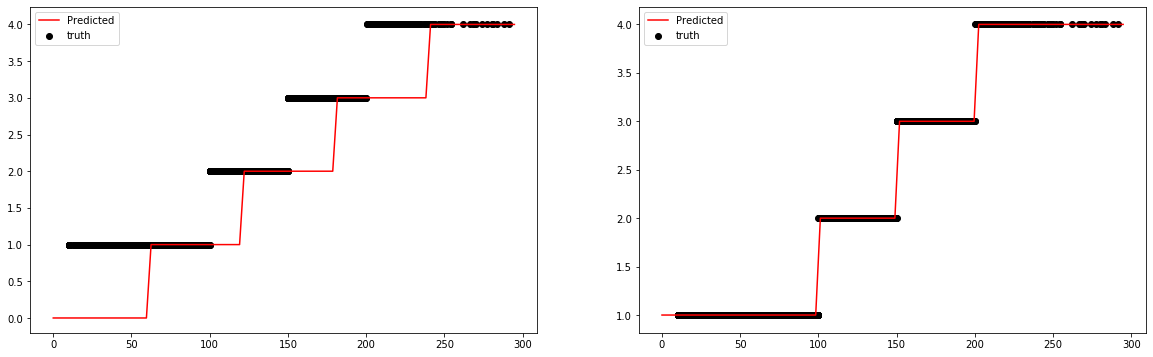

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)

holder_index = 2
testing = pd.DataFrame({'amount': np.linspace(0, DR_X_test['amount'].max(), 100), 'holder_index': holder_index})
sub_test = df[df['holder_index']==holder_index]

LR_predictions = DR_lr_pipeline.predict(testing).astype(int)
plt.subplot(121)
plt.plot(testing['amount'], LR_predictions, color='red', label='Predicted')
plt.scatter(sub_test['amount'], sub_test['dispute_risk'], color='black', label='truth')
plt.legend()
plt.subplot(122)
RF_predictions = DR_rf_pipeline.predict(testing).astype(int)
plt.plot(testing['amount'], RF_predictions, color='red', label='Predicted')
plt.scatter(sub_test['amount'], sub_test['dispute_risk'], color='black', label='truth')
plt.legend()

## Card Holder (CH) model

In [12]:
CH_outputs = df['holder_risk']
CH_inputs = df[['age', 'holder_index', 'incidents']]

CH_X_train, CH_X_test, CH_y_train, CH_y_test = train_test_split(CH_inputs, CH_outputs, test_size=0.4, random_state=23)

### Linear regression

In [13]:
CH_lr_pipeline = builder.build_LR_pipeline(CH_X_train, CH_y_train)

In [14]:
CH_lr_predictions = CH_lr_pipeline.predict(CH_X_test)
print(CH_lr_pipeline.score(CH_X_test, CH_y_test))

0.6094701245379215


### Random forest

In [15]:
CH_rf = builder.RF_estimation(CH_X_train, CH_y_train, estimator_steps=5, depth_steps=5)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [16]:
CH_rf_pipeline = builder.build_RF_pipeline(CH_X_train, CH_y_train, CH_rf)

In [17]:
CH_rf_predictions = CH_rf_pipeline.predict(CH_X_test)
print(CH_rf_pipeline.score(CH_X_test, CH_y_test))

1.0


In [18]:
CH_result = pd.DataFrame({'LR': CH_lr_predictions.astype(int), 'RF': CH_rf_predictions.astype(int), 'truth': CH_y_test})
CH_result.head(20)

,LR,RF,truth
6326,0,0,0
5185,0,1,1
2495,0,0,0
2765,0,0,0
9303,2,4,4
322,0,0,0
4164,1,1,1
7198,0,0,0
2626,1,1,1
4492,0,1,1
